
# DCAE: Deep Convolutional Autoencoder

> This notebook encodes the data using the autoencoder described in [TimeCluster](https://link.springer.com/article/10.1007/s00371-019-01673-y).

## Set-up
Initial notebook setup and specific debugging and pre-configured cases selection.
### VsCode update patch
Initial notebook setup when using VSCode.

In [1]:
# This is only needed if the notebook is run in VSCode
import sys
if '--vscode' in sys.argv:
    print("Executing inside vscode")
    import nbs_pipeline.utils.vscode  as vs
    vs.DisplayHandle.update = vs.update_patch

### Debugging variables

- `print_flag`. If `True` it adds debbuging messages in those functions that allows so.
- `reset_kernel`. If `True` it resets the kernel by the end of the execution. Use only in case that memory management is needed.
- `check_memory_usage`. If `True`, it adds some lines for checking the GPU memmory ussage along the execution.
- `time_flag`. If `True` it get the execution time along the notebook as well as inside those functions that allows so.
- `window_size_percentage`. If `True`, MVP will be used directly with the proposed windows sizes. Otherwise, it will be asumed that they have been taken as absolute values and execution will be take that into account.

In [2]:
print_flag = True
reset_kernel = True
check_memory_usage = True
time_flag = True
window_size_percentage = False

## Preconfigurated cases selection
- `pre_configured_case`. If `True`, a preconfigured case will be selected, forcing the artifact to get the expected configuration based on the information in `config\*.yml` and `utils\config.py`.
- `case_id`. If `preconfigured_case` is `True`, it forces to select the configuration of the `case_id` preconfigured samples. The available preconfigured samples are shown in the next cell.
- `frequency_factor`. If `pre_configured_case` is `True`, frequency will be resampled by `config.freq*frequency_factor`
  `frequency_factor_change_alias`. If `pre_configured_case` is `True` and `frequency_factor != 1` then the dataset alias will be modified for adding the new frequency as suffix.

In [3]:
import utils.config as cfg_
cfg_.show_available_configs()

Available datasets: 
0 - monash_australian_electricity_demand_0
1 - monash_solar_4_seconds_0
2 - wikipedia_0
3 - traffic_san_francisco_0
4 - monash_solar_10_minutes_0
5 - etth1_0
6 - stumpy_abp_0
7 - stumpy_toy_0


In [4]:
pre_configured_case = True
case_id = 1
frequency_factor = 5
frequency_factor_change_alias = True

## Main code
### Import libraries

In [5]:
try:
    from tsai.all import *
except:
    from tsai.all import * # TODO: Weird error when loading tsai!from tchub.all import *
from fastcore.all import *
from fastai.callback.wandb import WandbCallback
from fastai.callback.schedule import *
from dvats.all import *
import wandb
if check_memory_usage: 
    import nbs_pipeline.utils.memory as mem

For the experiment tracking and hyperparameter we will use the tool **Weights & Biases**. 

Before running this notebook, make sure you have the `$WANDB_API_KEY` environment varibale defined with your API_KEY (run in a terminal `echo $WANDB_API_KEY` to see it). If not, run in a terminal `wandb login [API_KEY]`. You can see your API_KEY [here](https://wandb.ai/authorize) or in the settings of your W&B account.

### Initialize and Configurate Artifact

In [6]:
wandb_api = wandb.Api()

#### Setup CUDA

In [7]:
cuda_device = 0
device = torch.device(f'cuda:{cuda_device}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
if check_memory_usage:
    gpu_device = torch.cuda.current_device()
    mem.gpu_memory_status(gpu_device)

GPU | Used mem: 519
GPU | Used mem: 24576
GPU | Memory Usage: [--------------------] 2%


#### Get configutation from yml
> This file used the configuration files './config/base.yml' and './config/02a_encoder_DCAE.ipynb'

In [8]:
import nbs_pipeline.utils.config as cfg
dcae_config, job_type = cfg.get_artifact_config_DCAE(print_flag = print_flag)
if pre_configured_case: 
    cfg_.force_artifact_config_dcae(
        config = dcae_config,
        id = case_id,
        print_flag = print_flag, 
        both = print_flag,
        frequency_factor = frequency_factor,
        frequency_factor_change_alias = frequency_factor_change_alias
    )

if print_flag: cfg_.show_attrdict(dcae_config)

-----------Project configuration-----------
user: mi-santamaria
project: deepvats
version: latest
data: Monash-Australian_electricity_demand:latest
-----------Project configuration-----------
Current: /home/macu/work/nbs_pipeline
yml: ./config/02a-encoder_dcae.yaml
Getting content./config/02a-encoder_dcae.yaml
... About to replace includes with content
Load content./config/02a-encoder_dcae.yaml
Antes de leer configuration {'include': None, 'user_preferences': {'use_wandb': True, 'wdb': {'user': 'mi-santamaria', 'project_name': 'deepvats', 'version': 'latest', 'mode': 'online', 'artifacts_path': './data/wandb_artifacts'}, 'data': {'folder': '~/data/', 'fname': 'australian_electricity_demand_dataset', 'ftype': '.tsf', 'cols': [0], 'freq': '1h'}, 'artifact': {'alias': 'Monash-Australian_electricity_demand', 'algorithm': 'mvp-SWV'}, 'directories': {'tmp': 'tmp', 'data': '~/data/australian_electricity_demand_dataset.tsf'}}, 'data': {'name': 'australian_electricity_demand_dataset', 'path': '

### Setup W&B artiffact

In [9]:
path = os.path.expanduser("~/work/nbs_pipeline/")
name="02a_encoder_DCAE-sliding_window_view"
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"
runname=name
print("runname: "+runname)

runname: 02a_encoder_DCAE-sliding_window_view


In [10]:
#hide
run = wandb.init(
    entity          = dcae_config.wandb_entity,
    project         = dcae_config.wandb_project,
    group           = dcae_config.wandb_group,
    job_type        = job_type,
    allow_val_change= True,
    mode            = 'online' if dcae_config.use_wandb else 'disabled',
    config          = dcae_config,
    anonymous = 'never' if dcae_config.use_wandb else 'must', 
    resume=False,
    name = runname
)
dcae_config = run.config  # Object for storing hyperparameters
artifacts_gettr = run.use_artifact if dcae_config.use_wandb else wandb_api.artifact

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find /home/macu/work/nbs_pipeline/02a_encoder_DCAE-sliding_window_view.ipynb.
wandb: Currently logged in as: mi-santamaria. Use `wandb login --relogin` to force relogin


'stream.Stream' object attribute 'write' is read-only


## Loading the datasets

To load the dataset we will download a specific dataset artifact from the collection of artifacts
stored in the weights and biases (wandb) project associated to this experiment.

### Sliding window features

Define a continuous multivariate time-series data $D$ of dimension $d$ with $n$ time-steps, $D = X_1,X_2,\dots,X_n$ , where each $X_i = \{x_i^1,\dots,x_i^d\}$ . Let $w$ be the window width, $s$ the stride, and $t$ the start time of a sliding window in the data.

Define a new matrix $Z_k$ where each row is a vector of size $w$ of data extracted from the $k^{th}$ dimension.

\begin{aligned}&Z_k(w,s,t)\\&\quad =\begin{bmatrix} x_{t}^k&\quad x_{t+1}^k&\quad \dots&\quad x_{t+w-1}^k \\ x_{t+s}^k&\quad x_{t+s+1}^k&\quad \dots&\quad x_{t+s+w-1}^k \\ \vdots&\quad \vdots&\quad \ddots&\quad \vdots \\ x_{t+(r-1)s}^k&\quad x_{t+(r-1)s+1}^k&\quad \dots&\quad x_{t+(r-1)s+w-1}^k \end{bmatrix} \end{aligned}

where $r$ is the number of desired rows, and $t+(r-1)s+w-1 \le n$


$Z$ is a $w \times s \times t$ matrix. The first step consists in slicing the original multivariate time series into slices of shape ($w \times d$), as shown in this figure from the paper.
<img src="https://i.imgur.com/R9Fx8uO.png" style="width:800px;height:400px"/>

The hyperparameters of this sliding window approach are given values by default here. If the value has been already set previously, that means this notebook is being called from a wandb sweep, and we must use the value that the sweep is bringing.

In [11]:
sw = SlidingWindow(window_len=dcae_config.w, stride=dcae_config.stride, get_y=[])

In [12]:
train_artifact = artifacts_gettr(dcae_config.train_artifact)
df_train = train_artifact.to_df()
X_train, _ = sw(df_train)
df_train.shape, X_train.shape

wandb:   1 of 1 files downloaded.  


((1479445, 1), (30818, 1, 224))

In [13]:
if dcae_config.valid_artifact:
    valid_artifact = artifacts_gettr(dcae_config.valid_artifact)
    df_val = valid_artifact.to_df()
    X_valid, _ = sw(df_val)
    df_val.shape, X_valid.shape

## Extract important features from the multivariate time series data through Deep Convolutional Autoencoders


Deep Convolutional Auto Encoders (DCAE) is a powerful method for learning high-level and mid-level abstractions from low-level raw data. It has the ability to extract features from complex and large time-series in an unsupervised manner. This is useful to overcome the complexity of multivariate time-series.

Compared to the conventional auto-encoder, DCAE has fewer parameters than the conventional auto-encoder which means less training time. Also, DCAE uses local information to reconstruct the signal while conventional auto-encoders utilize fully connected layers to globally do the reconstruction. DCAE is an unsupervised model for representation learning which maps inputs into a new representation space. It has two main parts which are the encoding part that is used to project the data into a set of feature spaces and the decoding part that reconstructs the original data. The latent space representation is the space where the data lie in the bottleneck layers.

The loss function of the DCAE is defined as the error between the input and the output. DCAE aims to find a code for each input by minimizing the mean squared error (MSE) between its input (original data) and output (reconstructed data). The MSE is used which assists to minimize the loss; thus, the network is forced to learn a low-dimensional representation of the input.

We will implement the DCAE of the paper [TimeCluster](https://link.springer.com/article/10.1007/s00371-019-01673-y), whose architecture is shown in the table below:

![](https://i.imgur.com/3EjuAfQ.png)

Note that, in the paper, the input shape is $60 \times 3$, due to multivariate time series has 3 variables and the window size is 60. Generally, the size of the input/output of the autoencoder will depend on the shape of each slice obtained in the previos step. The number of latent features to be discovered is $60$ in the table above, but we can consider this as a free hyperparameter $\delta$. Also, according to the paper: "*The number of feature maps, size of filter and depth of the model are set based on the reconstruction error on validation set.*". Thus, we must provide flexibility in the creation of the DCAE in terms of these hyperparameters.º

In case you are not using a config file, you can also uncomment the following cell and define the hyperparameters in the fly

In [14]:
all_equal([len(x) for x in [dcae_config.nfs, dcae_config.kss, dcae_config.pool_szs]], 
          np.repeat(len(dcae_config.nfs), 3))

True

### Create the model

The implementation of the DCAE is done using Keras.

In [15]:
m = DCAE_torch(
    c_in=X_train.shape[1], 
    seq_len=dcae_config.w, 
    delta=dcae_config.delta, 
    pool_szs=dcae_config.pool_szs, 
    nfs=dcae_config.nfs
)
print(m)
foo = torch.rand(1, X_train.shape[1], dcae_config.w)
foo.shape, m(foo).shape

DCAE_torch(
  (downsample): Sequential(
    (0): SameConv1d(
      (conv1d_same): Conv1d(1, 64, kernel_size=(10,), stride=(1,))
    )
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv1d(64, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(32, 16, kernel_size=(5,), stride=(1,), padding=(2,))
    (5): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (bottleneck): Sequential(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (latent_in): Linear(in_features=224, out_features=60, bias=True)
    (latent_out): Linear(in_features=60, out_features=224, bias=True)
    (reshape): Reshape(bs, 16, 14)
  )
  (upsample): Sequential(
    (0): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): Upsample(scale_factor=4.0, mode=nearest)
    (2): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    

(torch.Size([1, 1, 224]), torch.Size([1, 1, 224]))

Train the model with fastai Learner class, to abstract from Pytorch's training loop

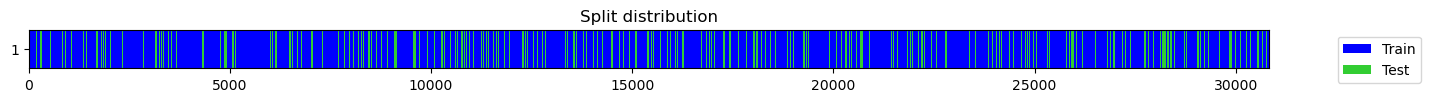

((#24655) [145,12091,20910,5935,18889,24604,8822,21666,10051,17917...],
 (#6163) [2624,17814,8799,2844,11958,2190,16188,22277,21054,21860...])

In [16]:
if dcae_config.valid_artifact:
    X, y, splits  = combine_split_data(xs=[X_train, X_valid], ys=[X_train, X_valid])
else:
    X = X_train
    y = X_train
    splits = get_splits(np.arange(len(X)), valid_size=dcae_config.valid_size)
splits

(<Axes: >, <Axes: >)

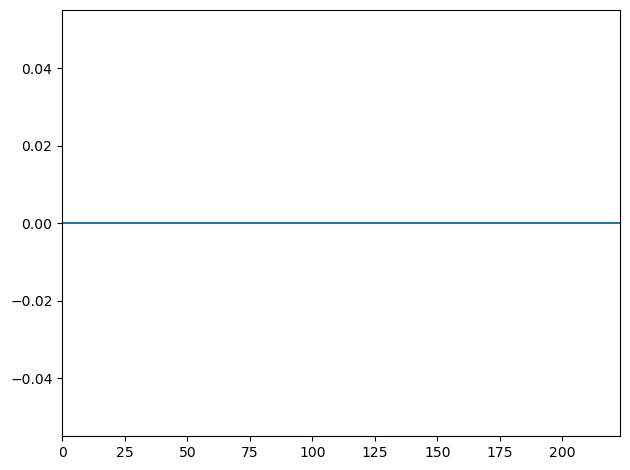

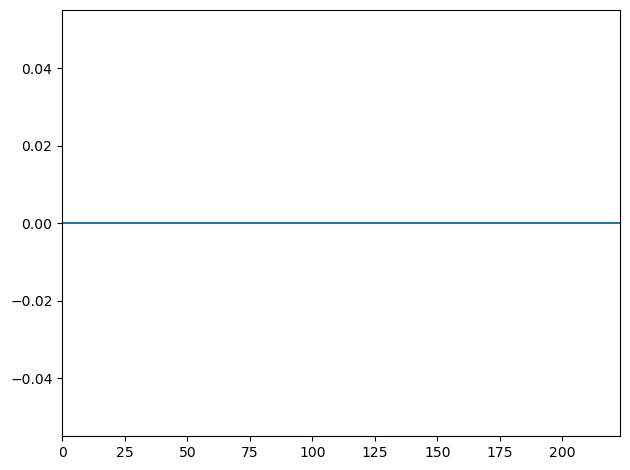

In [17]:
tfms = [ToFloat(), ToFloat()]
batch_tfms = [TSStandardize(by_sample=True)]
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms)
dls.dataset[0][0].show(), ToTSTensor()(dls.dataset[0][1]).show()

In [ ]:
m = DCAE_torch(c_in=X_train.shape[1], seq_len=dcae_config.w, delta=dcae_config.delta, 
               pool_szs=dcae_config.pool_szs, nfs=dcae_config.nfs)
learn = Learner(dls=dls, model=m, loss_func=nn.MSELoss(), opt_func=Adam, 
                cbs=[WandbCallback(log_preds=False)])
lr_valley, lr_steep = learn.lr_find(suggest_funcs=[valley, steep])
learn.fit_one_cycle(dcae_config.epochs, lr_max=lr_valley)
learn.plot_metrics()

epoch     train_loss  valid_loss  time    
0         2858.088135 2804.222900 00:04     
1         2839.671875 2779.152100 00:04     





To track the performance of this model fit, go to the project dashboard in Weights & Biases. The link is provided at the beginning of this notebook, after the execution of the function `wandb.init()'' 

Finally, log the learner to be used by the next notebook in the pipeline

In [ ]:
aux_learn = learn.export_and_get()
if config.use_wandb: 
    ar = ReferenceArtifact(aux_learn, f'dcae', type='learner', metadata=dict(run.dcae_config))
    run.log_artifact(ar, aliases=f'run-{run.project}-{run.id}')

## Baseline models (To rewrite)

Calculate baseline models taking into account that the best prediction is the average and median value of each of the windows

## Validate the autoencoder

Let's validate the autoencoder quality visually:

#### Get the best and the worst k predictions using the autoencoder

In [ ]:
interp = Interpretation.from_learner(learn)

In [ ]:
top_losses = interp.top_losses(3)
top_losses

In [ ]:
#for i in top_losses.indices: dls.dataset[i][0].show()

In [ ]:
run.finish()

<class 'NameError'>: name 'run' is not defined